In [1]:
import zipfile
import os

zip_file_path = "/content/lipreading (4).zip"
extract_to = "/content/dataset"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")

Files extracted to /content/dataset


In [2]:
def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} word in '{dirpath}'.")

In [3]:
walk_through_dir('/content/dataset/lipreading/lipreading')

There are 10 directories and 0 word in '/content/dataset/lipreading/lipreading'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/تعب'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/انا'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/اكتئاب'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/اكسجين'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/شكرا'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/صوت'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/برد'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/اريد'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/اشعر'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/جوع'.


In [8]:
import os

dir_path = "/content/lipreading/اخبارك/.ipynb_checkpoints"

if os.path.exists(dir_path) and os.path.isdir(dir_path):
    os.rmdir(dir_path)  # Removes only empty directories
    print(f"{dir_path} has been deleted.")
else:
    print(f"{dir_path} is not a valid directory or does not exist.")

/content/lipreading/اخبارك/.ipynb_checkpoints is not a valid directory or does not exist.


In [4]:
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [5]:
main_dir = "/content/dataset/lipreading/lipreading"
classes = os.listdir(main_dir)  # List all class folders

In [11]:
classes

['تعب', 'انا', 'اكتئاب', 'اكسجين', 'لا', 'شكرا', 'صوت', 'برد', 'اريد', 'اشعر']

In [12]:
class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

In [13]:
max_shape = None

# Step 1: Identify the maximum shape among all .npy files
for class_dir in class_to_idx:
    class_path = os.path.join(main_dir, class_dir)
    if os.path.isdir(class_path):  # Ensure it's a directory
        for npy_file in os.listdir(class_path):
            if npy_file.endswith('.npy'):
                file_path = os.path.join(class_path, npy_file)
                data = np.load(file_path)
                if max_shape is None:
                    max_shape = data.shape
                else:
                    max_shape = tuple(max(max_shape[dim], data.shape[dim]) for dim in range(len(data.shape)))

In [14]:
# Step 2: Pad files to the maximum shape
for class_dir in class_to_idx:
    class_path = os.path.join(main_dir, class_dir)
    if os.path.isdir(class_path):  # Ensure it's a directory
        for npy_file in os.listdir(class_path):
            if npy_file.endswith('.npy'):
                file_path = os.path.join(class_path, npy_file)
                data = np.load(file_path)

                # Calculate padding sizes
                padding = [(0, max_dim - curr_dim) for curr_dim, max_dim in zip(data.shape, max_shape)]

                # Apply padding
                padded_data = np.pad(data, pad_width=padding, mode='constant', constant_values=0)

                # Save the padded file (overwrite or save to a new location)
                np.save(file_path, padded_data)

print("Padding completed. All files have the shape:", max_shape)

Padding completed. All files have the shape: (83, 512)


## Custom Data

In [15]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [16]:
class LipReadingDataset(Dataset):
    def __init__(self, file_paths, labels, pad_value=0):
        self.file_paths = file_paths
        self.labels = labels
        self.pad_value = pad_value

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        data = np.load(self.file_paths[idx])
        label = self.labels[idx]

        # Create padding mask (1 for valid, 0 for padded)
        mask = (data != self.pad_value).astype(np.float32)

        # Flatten the input to match the model's expected input_size
        data = data.flatten()
        mask = mask.flatten()

        return torch.tensor(data, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32), label

## Split Data

In [17]:
# Directory containing class folders
classes = class_to_idx

# Collect file paths and corresponding labels
file_paths = []
labels = []
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

for class_dir in classes:
    class_path = os.path.join(main_dir, class_dir)
    if os.path.isdir(class_path):
        for npy_file in os.listdir(class_path):
            if npy_file.endswith('.npy'):
                file_paths.append(os.path.join(class_path, npy_file))
                labels.append(class_to_idx[class_dir])


## Dataloaders

In [18]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

In [19]:
# Create Dataset instances
train_dataset = LipReadingDataset(train_paths, train_labels)
test_dataset = LipReadingDataset(test_paths, test_labels)

In [20]:
from torch.utils.data import DataLoader

batch_size = 128

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data preparation complete.")
print(f"Train size: {len(train_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Data preparation complete.
Train size: 159
Test size: 40


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# Libraries I added

from torch.optim import Adam, SGD
import torchvision.models as models

In [24]:
class nnLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(nnLSTM, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layers after LSTM
        self.layer_1 = nn.Linear(hidden_size, 1024)
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 256)
        self.layer_4 = nn.Linear(256, output_size)

        # Activation function
        self.hidden_activation = nn.ReLU()

    def forward(self, x):
        # x shape is (batch_size, seq_length, input_size)

        # Pass input through LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Use the output from the last time step
        lstm_out_last = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Pass the LSTM output through the fully connected layers
        x = self.hidden_activation(self.layer_1(lstm_out_last))
        x = self.hidden_activation(self.layer_2(x))
        x = self.hidden_activation(self.layer_3(x))
        x = self.layer_4(x)

        return x

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Defining the device

model = nnLSTM(input_size=512*83, hidden_size=128, num_layers=4, output_size=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.1)

model.to(device) # Move everything to the device

nnLSTM(
  (lstm): LSTM(42496, 128, num_layers=4, batch_first=True)
  (layer_1): Linear(in_features=128, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=10, bias=True)
  (hidden_activation): ReLU()
)

In [ ]:
import torch
from sklearn.model_selection import KFold

# Hyperparameters
epoch_no = 20
k_folds = 5  # Number of folds
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# KFold cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Training fold {fold + 1}/{k_folds}...")

    # Split dataset into train and validation subsets for the current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    # Create data loaders for the current fold
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = nnLSTM(input_size=512*83, hidden_size=512, num_layers=2, output_size=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epoch_no):
        model.train()

        epoch_weighted_loss = 0
        correct_train = 0  # Initialize for training accuracy

        for batch_X, mask, batch_y in train_loader:
            batch_X = batch_X.view(-1, 1, 83 * 512).to(device)
            batch_y = batch_y.to(device)

            batch_y_probs = model(batch_X)

            # Calculate the loss
            loss = loss_fn(batch_y_probs, batch_y)

            mask = mask.to(loss.device)

            masked_loss = loss * mask
            loss = masked_loss.sum() / mask.sum()

            # Reset the gradient
            optimizer.zero_grad()

            # Loss backward
            loss.backward()

            # Optimizer step
            optimizer.step()

            epoch_weighted_loss += len(batch_y) * loss.item()

            # Calculate the accuracy
            train_batch_y_pred = batch_y_probs.argmax(dim=1)
            correct_train += (train_batch_y_pred == batch_y).sum().item()

        epoch_loss = epoch_weighted_loss / len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Validation time
        model.eval()
        correctly_labelled = 0

        with torch.no_grad():
            val_epoch_weighted_loss = 0
            for val_batch_X, mask, val_batch_y in val_loader:
                val_batch_X = val_batch_X.view(-1, 1, 83 * 512).to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_probs = model(val_batch_X)
                loss = loss_fn(val_batch_y_probs, val_batch_y)

                val_epoch_weighted_loss += len(val_batch_y) * loss.item()

                val_batch_y_pred = val_batch_y_probs.argmax(dim=1)
                correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

            val_epoch_loss = val_epoch_weighted_loss / len(val_loader.dataset)
            val_accuracy = correctly_labelled / len(val_loader.dataset)
            val_losses.append(val_epoch_loss)
            val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch}: train_loss={epoch_loss:.4f}, val_loss={val_epoch_loss:.4f}, '
              f'val_accuracy={val_accuracy * 100:.2f}%')

    print(f'Fold {fold + 1} complete.')

print(f'Training complete across {k_folds} folds.')

Training fold 1/5...
Epoch 0: train_loss=2.3035, val_loss=2.3154, val_accuracy=6.25%
Epoch 1: train_loss=2.2989, val_loss=2.3258, val_accuracy=12.50%
Epoch 2: train_loss=2.2911, val_loss=2.3336, val_accuracy=9.38%
Epoch 3: train_loss=2.2746, val_loss=2.3571, val_accuracy=9.38%
Epoch 4: train_loss=2.2391, val_loss=2.3850, val_accuracy=12.50%
Epoch 5: train_loss=2.1740, val_loss=2.5727, val_accuracy=9.38%
Epoch 6: train_loss=2.1035, val_loss=2.4363, val_accuracy=9.38%
Epoch 7: train_loss=2.0718, val_loss=2.5930, val_accuracy=15.62%
Epoch 8: train_loss=1.8464, val_loss=3.7709, val_accuracy=3.12%
Epoch 9: train_loss=2.0606, val_loss=2.6287, val_accuracy=15.62%
Epoch 10: train_loss=1.6771, val_loss=2.2652, val_accuracy=21.88%
Epoch 11: train_loss=1.7552, val_loss=2.1516, val_accuracy=25.00%
Epoch 12: train_loss=1.5940, val_loss=2.2117, val_accuracy=31.25%
Epoch 13: train_loss=1.3209, val_loss=2.3769, val_accuracy=18.75%
Epoch 14: train_loss=1.1636, val_loss=2.6156, val_accuracy=28.12%
Epoch

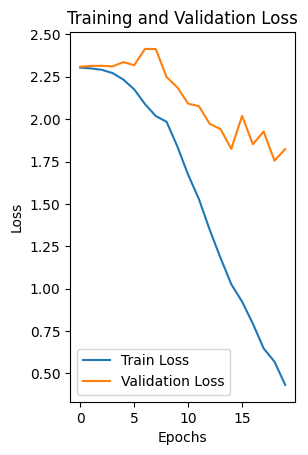

In [ ]:
# After K-fold cross-validation, average the losses
avg_train_losses = np.mean(np.array(train_losses).reshape(k_folds, epoch_no), axis=0)
avg_val_losses = np.mean(np.array(val_losses).reshape(k_folds, epoch_no), axis=0)

# Now plot the average losses
plt.subplot(1, 2, 1)
plt.plot(range(epoch_no), avg_train_losses, label='Train Loss')
plt.plot(range(epoch_no), avg_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
from sklearn.metrics import precision_score, confusion_matrix
confusion_matrices = []

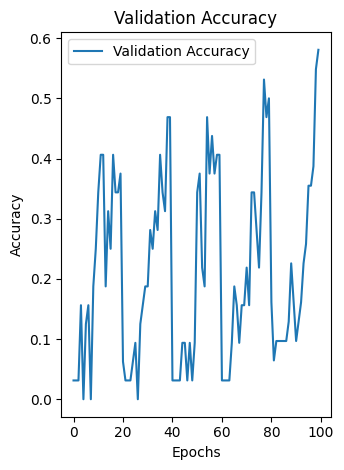

In [ ]:
# Plot training and validation accuracy for LSTM model with 5k folds
plt.subplot(1, 2, 2)
#plt.plot(range(epoch_no), train_accuracies, label='Train Accuracy')
plt.plot(range(100), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score
import pandas as pd


Training fold 1/5...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0: train_loss=2.3058, val_loss=2.3028, val_accuracy=0.00%
Epoch 1: train_loss=2.3012, val_loss=2.3129, val_accuracy=0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2: train_loss=2.2942, val_loss=2.3227, val_accuracy=0.00%
Epoch 3: train_loss=2.2797, val_loss=2.3302, val_accuracy=0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4: train_loss=2.2535, val_loss=2.3499, val_accuracy=9.38%
Epoch 5: train_loss=2.2005, val_loss=2.4004, val_accuracy=0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6: train_loss=2.1387, val_loss=2.4834, val_accuracy=9.38%
Epoch 7: train_loss=2.0734, val_loss=2.3699, val_accuracy=9.38%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8: train_loss=1.8593, val_loss=2.4547, val_accuracy=9.38%
Epoch 9: train_loss=1.6570, val_loss=2.5376, val_accuracy=9.38%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10: train_loss=1.5993, val_loss=2.3931, val_accuracy=12.50%
Epoch 11: train_loss=1.2553, val_loss=2.5353, val_accuracy=15.62%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12: train_loss=1.0065, val_loss=2.6116, val_accuracy=12.50%
Epoch 13: train_loss=0.9173, val_loss=3.0519, val_accuracy=12.50%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14: train_loss=0.8371, val_loss=2.3811, val_accuracy=31.25%
Epoch 15: train_loss=1.0369, val_loss=2.8185, val_accuracy=15.62%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16: train_loss=0.7429, val_loss=3.6995, val_accuracy=25.00%
Epoch 17: train_loss=0.6925, val_loss=2.6309, val_accuracy=34.38%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18: train_loss=0.5029, val_loss=2.3720, val_accuracy=37.50%
Epoch 19: train_loss=0.5786, val_loss=2.2651, val_accuracy=37.50%
Fold 1 complete.
Training fold 2/5...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0: train_loss=2.3030, val_loss=2.3102, val_accuracy=18.75%
Epoch 1: train_loss=2.2985, val_loss=2.3134, val_accuracy=15.62%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2: train_loss=2.2908, val_loss=2.3129, val_accuracy=9.38%
Epoch 3: train_loss=2.2740, val_loss=2.3091, val_accuracy=9.38%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4: train_loss=2.2413, val_loss=2.2880, val_accuracy=6.25%
Epoch 5: train_loss=2.1935, val_loss=2.4049, val_accuracy=6.25%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6: train_loss=2.1717, val_loss=2.2168, val_accuracy=18.75%
Epoch 7: train_loss=2.0071, val_loss=2.1584, val_accuracy=25.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8: train_loss=1.8444, val_loss=2.6600, val_accuracy=3.12%
Epoch 9: train_loss=1.9658, val_loss=2.1465, val_accuracy=21.88%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10: train_loss=1.7383, val_loss=1.9603, val_accuracy=34.38%
Epoch 11: train_loss=1.5548, val_loss=1.9745, val_accuracy=28.12%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12: train_loss=1.3649, val_loss=1.9701, val_accuracy=28.12%
Epoch 13: train_loss=1.1733, val_loss=1.7815, val_accuracy=37.50%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14: train_loss=0.9718, val_loss=1.8573, val_accuracy=34.38%
Epoch 15: train_loss=0.8297, val_loss=1.6423, val_accuracy=34.38%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16: train_loss=0.7288, val_loss=2.0746, val_accuracy=43.75%
Epoch 17: train_loss=0.6454, val_loss=1.7897, val_accuracy=53.12%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18: train_loss=0.5201, val_loss=2.0851, val_accuracy=53.12%
Epoch 19: train_loss=0.3760, val_loss=2.2699, val_accuracy=46.88%
Fold 2 complete.
Training fold 3/5...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0: train_loss=2.3023, val_loss=2.3138, val_accuracy=12.50%
Epoch 1: train_loss=2.2980, val_loss=2.3181, val_accuracy=9.38%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2: train_loss=2.2902, val_loss=2.3192, val_accuracy=12.50%
Epoch 3: train_loss=2.2734, val_loss=2.3194, val_accuracy=15.62%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4: train_loss=2.2406, val_loss=2.3055, val_accuracy=12.50%
Epoch 5: train_loss=2.1796, val_loss=2.3443, val_accuracy=21.88%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6: train_loss=2.0925, val_loss=2.2836, val_accuracy=12.50%
Epoch 7: train_loss=1.9535, val_loss=2.3431, val_accuracy=18.75%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8: train_loss=1.7316, val_loss=2.1930, val_accuracy=31.25%
Epoch 9: train_loss=1.4975, val_loss=2.6976, val_accuracy=12.50%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10: train_loss=1.5580, val_loss=2.2464, val_accuracy=25.00%
Epoch 11: train_loss=1.5323, val_loss=2.1233, val_accuracy=28.12%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12: train_loss=1.3664, val_loss=1.9264, val_accuracy=34.38%
Epoch 13: train_loss=0.9403, val_loss=2.0790, val_accuracy=40.62%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14: train_loss=0.9664, val_loss=1.6172, val_accuracy=40.62%
Epoch 15: train_loss=0.7638, val_loss=1.9415, val_accuracy=46.88%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16: train_loss=0.6299, val_loss=1.9901, val_accuracy=43.75%
Epoch 17: train_loss=0.5081, val_loss=1.6306, val_accuracy=31.25%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18: train_loss=0.4383, val_loss=1.6911, val_accuracy=46.88%
Epoch 19: train_loss=0.3272, val_loss=1.6730, val_accuracy=53.12%
Fold 3 complete.
Training fold 4/5...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0: train_loss=2.3011, val_loss=2.3157, val_accuracy=3.12%
Epoch 1: train_loss=2.2972, val_loss=2.3189, val_accuracy=3.12%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2: train_loss=2.2903, val_loss=2.3140, val_accuracy=9.38%
Epoch 3: train_loss=2.2733, val_loss=2.3135, val_accuracy=3.12%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4: train_loss=2.2467, val_loss=2.2982, val_accuracy=12.50%
Epoch 5: train_loss=2.2128, val_loss=2.2992, val_accuracy=3.12%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6: train_loss=2.1098, val_loss=2.2262, val_accuracy=15.62%
Epoch 7: train_loss=1.9714, val_loss=2.2507, val_accuracy=6.25%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8: train_loss=1.8502, val_loss=2.3109, val_accuracy=12.50%
Epoch 9: train_loss=1.9746, val_loss=1.9706, val_accuracy=31.25%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10: train_loss=1.6058, val_loss=2.1101, val_accuracy=28.12%
Epoch 11: train_loss=1.4796, val_loss=2.0667, val_accuracy=25.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12: train_loss=1.1127, val_loss=1.6527, val_accuracy=43.75%
Epoch 13: train_loss=0.9504, val_loss=1.8040, val_accuracy=46.88%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14: train_loss=0.6997, val_loss=2.0466, val_accuracy=34.38%
Epoch 15: train_loss=0.6582, val_loss=1.9508, val_accuracy=37.50%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16: train_loss=0.5722, val_loss=2.3016, val_accuracy=46.88%
Epoch 17: train_loss=0.3474, val_loss=1.8743, val_accuracy=50.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18: train_loss=0.3708, val_loss=1.9520, val_accuracy=50.00%
Epoch 19: train_loss=0.1589, val_loss=2.6073, val_accuracy=59.38%
Fold 4 complete.
Training fold 5/5...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0: train_loss=2.3019, val_loss=2.3144, val_accuracy=3.23%
Epoch 1: train_loss=2.2980, val_loss=2.3184, val_accuracy=3.23%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2: train_loss=2.2890, val_loss=2.3225, val_accuracy=6.45%
Epoch 3: train_loss=2.2706, val_loss=2.3276, val_accuracy=6.45%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4: train_loss=2.2316, val_loss=2.3199, val_accuracy=3.23%
Epoch 5: train_loss=2.1646, val_loss=2.4310, val_accuracy=3.23%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6: train_loss=2.1219, val_loss=2.3468, val_accuracy=6.45%
Epoch 7: train_loss=1.9407, val_loss=2.3835, val_accuracy=6.45%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8: train_loss=1.7670, val_loss=2.6110, val_accuracy=3.23%
Epoch 9: train_loss=1.6228, val_loss=2.2420, val_accuracy=16.13%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10: train_loss=1.4187, val_loss=2.3582, val_accuracy=22.58%
Epoch 11: train_loss=1.3075, val_loss=2.3995, val_accuracy=12.90%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12: train_loss=1.0181, val_loss=2.4889, val_accuracy=19.35%
Epoch 13: train_loss=0.9001, val_loss=2.3791, val_accuracy=32.26%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14: train_loss=0.8042, val_loss=2.2417, val_accuracy=41.94%
Epoch 15: train_loss=0.6389, val_loss=2.5437, val_accuracy=29.03%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16: train_loss=0.5066, val_loss=2.3894, val_accuracy=32.26%
Epoch 17: train_loss=0.3886, val_loss=2.4708, val_accuracy=32.26%
Epoch 18: train_loss=0.2421, val_loss=3.0912, val_accuracy=25.81%
Epoch 19: train_loss=0.1715, val_loss=2.5014, val_accuracy=54.84%
Fold 5 complete.
Training complete across 5 folds.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


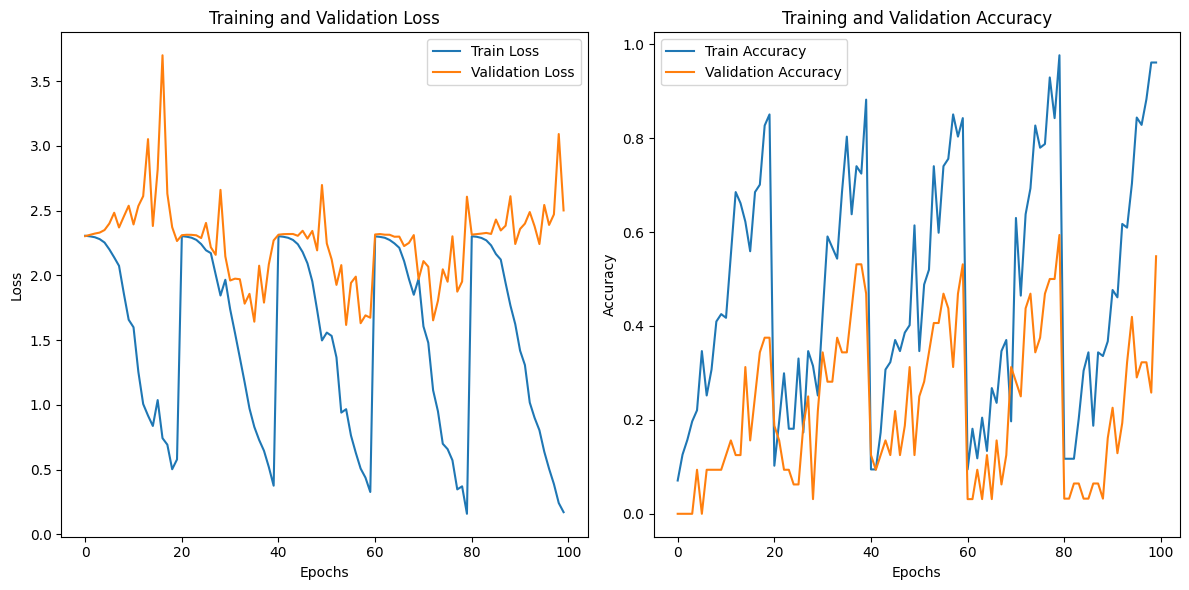

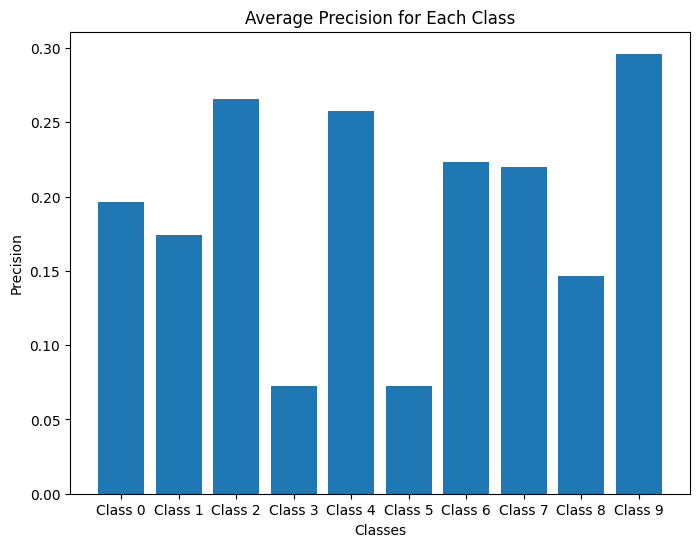

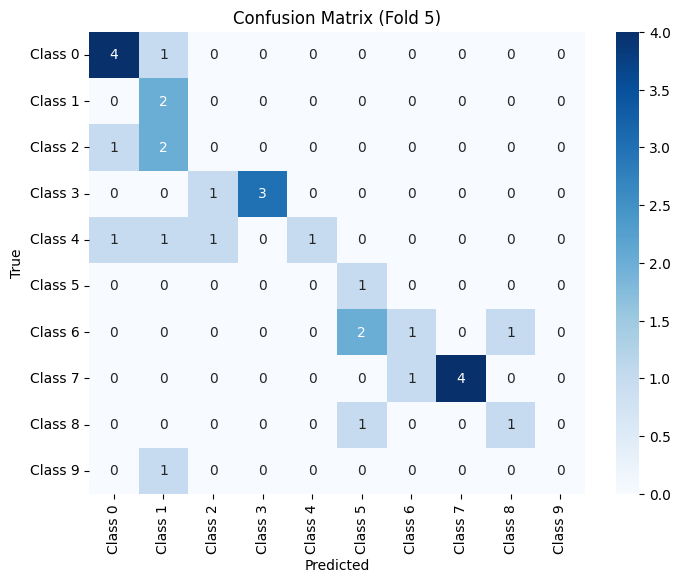

In [26]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, confusion_matrix
import seaborn as sns
import numpy as np

# Hyperparameters
epoch_no = 20
k_folds = 5  # Number of folds
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Track precision for each class
class_precision_train = []
class_precision_val = []

# KFold cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Training fold {fold + 1}/{k_folds}...")

    # Split dataset into train and validation subsets for the current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    # Create data loaders for the current fold
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = nnLSTM(input_size=512*83, hidden_size=512, num_layers=2, output_size=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epoch_no):
        model.train()

        epoch_weighted_loss = 0
        correct_train = 0  # Initialize for training accuracy
        all_train_preds = []
        all_train_labels = []

        for batch_X, mask, batch_y in train_loader:
            batch_X = batch_X.view(-1, 1, 83 * 512).to(device)
            batch_y = batch_y.to(device)

            batch_y_probs = model(batch_X)

            # Calculate the loss
            loss = loss_fn(batch_y_probs, batch_y)

            mask = mask.to(loss.device)

            masked_loss = loss * mask
            loss = masked_loss.sum() / mask.sum()

            # Reset the gradient
            optimizer.zero_grad()

            # Loss backward
            loss.backward()

            # Optimizer step
            optimizer.step()

            epoch_weighted_loss += len(batch_y) * loss.item()

            # Calculate the accuracy
            train_batch_y_pred = batch_y_probs.argmax(dim=1)
            correct_train += (train_batch_y_pred == batch_y).sum().item()

            # Store predictions and true labels for precision calculation
            all_train_preds.extend(train_batch_y_pred.cpu().numpy())
            all_train_labels.extend(batch_y.cpu().numpy())

        epoch_loss = epoch_weighted_loss / len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Validation time
        model.eval()
        correctly_labelled = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            val_epoch_weighted_loss = 0
            for val_batch_X, mask, val_batch_y in val_loader:
                val_batch_X = val_batch_X.view(-1, 1, 83 * 512).to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_probs = model(val_batch_X)
                loss = loss_fn(val_batch_y_probs, val_batch_y)

                val_epoch_weighted_loss += len(val_batch_y) * loss.item()

                val_batch_y_pred = val_batch_y_probs.argmax(dim=1)
                correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

                # Store predictions and true labels for precision calculation
                all_val_preds.extend(val_batch_y_pred.cpu().numpy())
                all_val_labels.extend(val_batch_y.cpu().numpy())

            val_epoch_loss = val_epoch_weighted_loss / len(val_loader.dataset)
            val_accuracy = correctly_labelled / len(val_loader.dataset)
            val_losses.append(val_epoch_loss)
            val_accuracies.append(val_accuracy)

            # Calculate precision for the validation set
            precision_val = precision_score(all_val_labels, all_val_preds, average=None)
            class_precision_val.append(precision_val)

        print(f'Epoch {epoch}: train_loss={epoch_loss:.4f}, val_loss={val_epoch_loss:.4f}, '
              f'val_accuracy={val_accuracy * 100:.2f}%')

    print(f'Fold {fold + 1} complete.')

print(f'Training complete across {k_folds} folds.')

# Plotting visuals for accuracy and losses
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision for Each Class
average_precision_per_class = np.mean(class_precision_val, axis=0)  # Mean precision across folds
classes = [f'Class {i}' for i in range(len(average_precision_per_class))]
plt.figure(figsize=(8, 6))
plt.bar(classes, average_precision_per_class)
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Average Precision for Each Class')
plt.show()

# Plot Confusion Matrix for the Last Fold
cm = confusion_matrix(all_val_labels, all_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Fold {k_folds})')
plt.show()
